In [2]:
import os
import random
from joblib import load, dump
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import get_dcox_feature_importance
from utils import dynamic_c_index

DATA_DIR = ""
SPLIT_DIR = ""

np.random.seed(494)
os.getcwd()

'/voyager/projects/xgao/LiverTransplantation/mas'

### Reload Evaluated Matrix and Models

In [3]:
saved_model = load(f"experiments/models/mas/graft/cox_full.pkl")

In [35]:
saved_model = load("experiments/models/dynamic_models_pkl/dcox_graft.pkl")

### Feature Importance

In [4]:
greens = ["#014110", "#015510", "#016910", "#017d0f", "#01910f", "#01a50f", "#01b910", "#01cd0f", "#01d70f", "#01eb0f"] 
reds = ["#5f0000", "#730000", "#820000", "#910000", "#a50000", "#b40000", "#c30000", "#d70000", "#e60000", "#f50000"] 

def get_colors(coefs):
    colors = []
    i, j = 0, 0
    for co in coefs:
        if co > 0:
            colors.append(reds[i])
            i += 1
        else:
            colors.append(greens[j])
            j += 1
    return colors

In [18]:
def get_dcox_feature_importances(summary, save = False):
    plt.rcParams['font.size'] = 15
    coefs = pd.DataFrame(
        np.transpose(np.array([summary["coef"], summary["coef lower 95%"], summary["coef upper 95%"]])),
        index = np.array(summary.index),
        columns=["coefficient", "lower", "upper"]
    )
    coefs["lower_ci"] = coefs["coefficient"] - coefs["lower"]
    coefs["upper_ci"] = coefs["upper"] - coefs["coefficient"]
    non_zero = np.sum(coefs.iloc[:, 0] != 0)
    print("Number of non-zero coefficients: {}".format(non_zero))
    non_zero_coefs = coefs.query("coefficient != 0")
    coef_order = non_zero_coefs.abs().sort_values("coefficient").index

    coef_name = non_zero_coefs.loc[coef_order][-15:].index
    coef_val = non_zero_coefs.loc[coef_order][-15:]["coefficient"].values
    upper_ci = non_zero_coefs.loc[coef_order][-15:]["upper_ci"].values
    lower_ci = non_zero_coefs.loc[coef_order][-15:]["lower_ci"].values
    asymmetric_error = [lower_ci, upper_ci]
    
    _, ax = plt.subplots(figsize=(8, 8))
    # non_zero_coefs.loc[coef_order][-15:]["coefficient"].plot.barh(ax=ax, legend=False, xerr=asymmetric_error, capsize=3,
    #                                                               color="hotpink", edgecolor="black", alpha=0.8)

    ax.barh(coef_name, coef_val, xerr=asymmetric_error, capsize=3,
                color="hotpink", edgecolor="black", alpha=0.8)

    ax.set_xlabel("Cox regression coefficients magnitudes")
    # ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.set_frame_on(False)
    ax.grid(True)
    # plt.tight_layout()
    if save:
        plt.savefig(f"experiments/plots/feature_importance.pdf", bbox_inches='tight')
    plt.show()

In [9]:
dcox_index = list(saved_model.summary.index)
dcox_summary = saved_model.summary.copy()

name_map = {
"CAN_MALIG": "any previous malignancy",
"CAN_ETHNICITY_SRTR": "latino patient",
"CAN_RACE_SRTR_b'WHITE'": "white patient",
"REC_DGN2_4401.0": "secondary diagnosis:  LI:PLM: HEPATOMA (HCC) AND CIRRHOSIS",
"CAN_RACE_SRTR_b'BLACK'": "Patient ethnicity: African descent",
"CAN_HGT_CM": "patient height in cm",
"TFL_ALBUMIN": "(dynamic) serum albumin",
"TFL_PRIMARY_PAY_3.0": "(dynamic) public insurance - Medicare FFS (Fee for Service)",
"CAN_GENDER": "patient gender (female = 1)",
"REC_PRIMARY_PAY_2.0": "public insurance - Medicaid",
"REC_DGN2_4410.0": "secondary diagnosis: LI:PLM: OTHER SPECIFY (I.E., KLATZKIN TUMOR, LEIOMYSARCOMA)",
"REC_DGN2_4202.0": "secondary diagnosis: LI:CIRRHOSIS: TYPE B- HBSAG+",
"REC_DGN2_4208.0": "Secondary diagnosis: cryptogenic cirrhosis",
"REC_DGN_4202.0": "primary diagnosis: LI:CIRRHOSIS: TYPE B- HBSAG+",
"TFL_WGT_KG": "(dynamic) patient weight in kg",
"TFL_DIAB_DURING_FOL": "Diabetes during the follow-up period",

"TFL_PRIMARY_PAY_2.0": "(dynamic) public insurance - medicaid",
"DON_AGE": "calculated donor age in years",
"REC_HCV_STAT_b'N'": "HCV serology status (N)",
"REC_ACUTE_REJ_EPISODE_3.0": "No acute rejections between transplant and discharge",

"REC_AGE_AT_TX": "Patient age at tansplant",
"TFL_HOSP": "(Most recent) patient hospitalized (over past 1 year)",
"TFL_ALBUMIN": "(Most recent) patient serum albumin",
"TFL_TOT_BILI": "(Most recent) patient total bilirubin",
"TFL_SGOT": "(Most recent) patient SGOT/AST",
"TFL_SGPT": "(Most recent) patient SGPT/ALT",
"TFL_INR": "(Most recent) patient INR",
"TFL_CREAT": "(Most recent) patient serum creatinine",
"TFL_WGT_KG": "(Most recent) patient weight",
"TFL_PRIMARY_PAY_15.0": "(Most Recent) unknown",
"DON_AGE": "Age of donor",
"CAN_DIAB_TY_1.0": "Patient Without Diabetes",
"REC_POSTX_LOS": "Patient Hospital Time After Transplant",
"REC_PRIMARY_PAY_1.0": "Patient with Private Insurance",
"REC_WORK_INCOME": "currently working for income"
}

def safe_map(val):
    try:
        return name_map[val]
    except KeyError:
        return val

dcox_index = list(map(lambda x: safe_map(x), dcox_index))
dcox_summary["new_index"] = dcox_index
dcox_summary.set_index("new_index", inplace=True)

Number of non-zero coefficients: 263


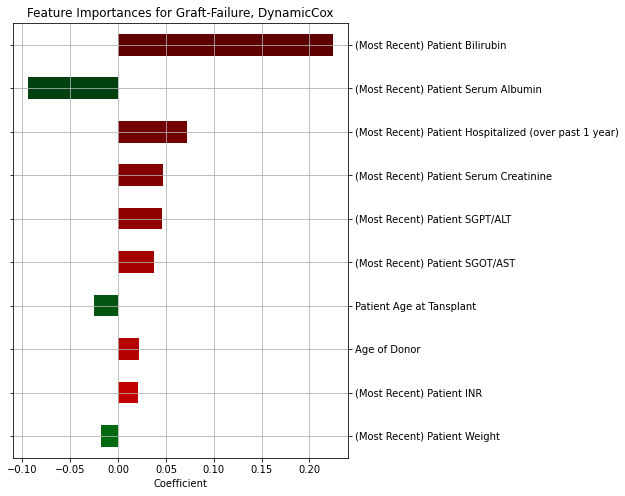

In [74]:
get_dcox_feature_importance(dcox_summary, "DynamicCox", "Graft-Failure", save=True)

Number of non-zero coefficients: 287


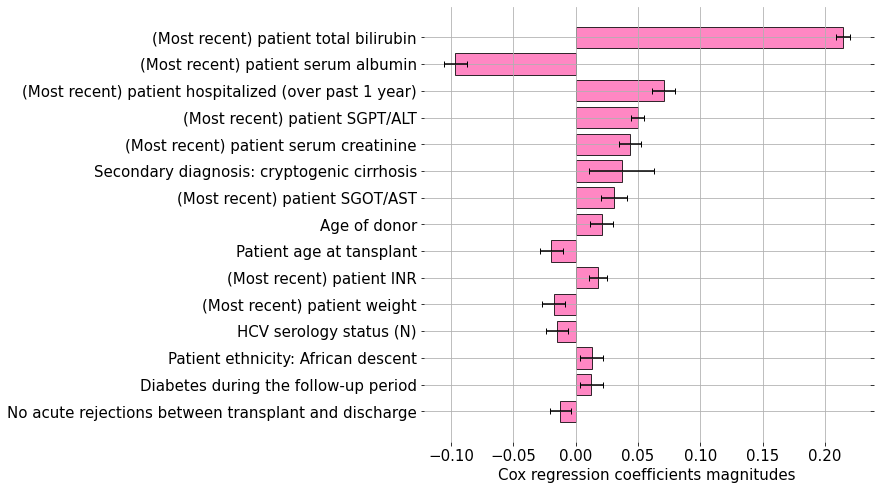

In [19]:
get_dcox_feature_importances(dcox_summary, save=True)

Number of non-zero coefficients: 287


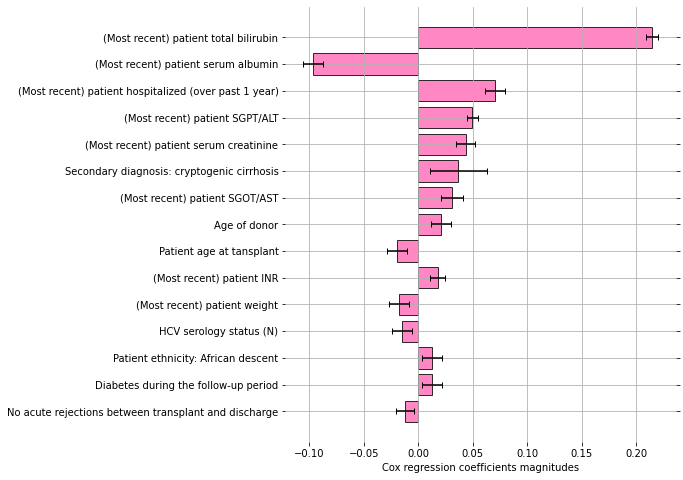

In [11]:
get_dcox_feature_importances(dcox_summary, save=True)

### Sample Patient Risk Trajectory

In [99]:
def subplot_MELD_constitent(axs, i, df, col_name, px_id, final_status):
    plt_color = "red" if final_status == 1 else "gray" 
    y, x = df["start"], df[col_name]
    axs[i].plot(y, x, color=plt_color)
    axs[i].set(ylabel=col_name, xlabel="Years Since Transplant", title=f"Patient {col_name} Score Over Time")# (PX_ID: {px_id})")
    for date in y:
        axs[i].axvline(x=date, linestyle="--", color="black")
    event_color = "red" if final_status == 1 else "green" 
    axs[i].axvline(x=list(df["TIME"])[0], linestyle="--", color=event_color)

# px_id = 731790.0
def make_multivariable_longitudinal_plot(df, px_id, outcome, save=False):
    # Set their final status
    final_status = None
    rows = df[df["PX_ID"] == px_id]
    if list(rows["EVENT"])[0] == 1:
        # graft failure
        final_status = 1
    else:
        # censored
        final_status = -1
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 1))
    subplot_MELD_constitent(axs, 0, rows, "DynamicCox", px_id, final_status)
    subplot_MELD_constitent(axs, 1, rows, "DynamicCox-\u0394", px_id, final_status)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.6)

    if save:
        plt.savefig(f"experiments/plots/scores/{px_id}-{outcome}-risk--track.png", bbox_inches='tight')



In [79]:
graft_df = dcox_graft_df.copy()
graft_df.rename(columns={"RISK":"DynamicCox"}, inplace=True)
graft_df["DynamicCox-\u0394"] = dcox_graft_delta_df["RISK"]

In [91]:
graft_df[graft_df["PX_ID"] == 689395.0]

,PX_ID,EVENT,TIME,start,DynamicCox,DynamicCox-Δ
58720,689395.0,0.0,8.0,0.000000,0.932591,0.951275
58721,689395.0,0.0,8.0,0.490411,1.003347,1.039091
58722,689395.0,0.0,8.0,0.961644,1.066617,1.092528
58723,689395.0,0.0,8.0,1.997260,0.852397,0.813038
58724,689395.0,0.0,8.0,2.980822,0.863696,0.892657
58725,689395.0,0.0,8.0,4.000000,0.835407,0.834131
58726,689395.0,0.0,8.0,4.967123,0.825664,0.826875
58727,689395.0,0.0,8.0,5.986301,0.823493,0.841308
58728,689395.0,0.0,8.0,7.002740,0.824216,0.845451


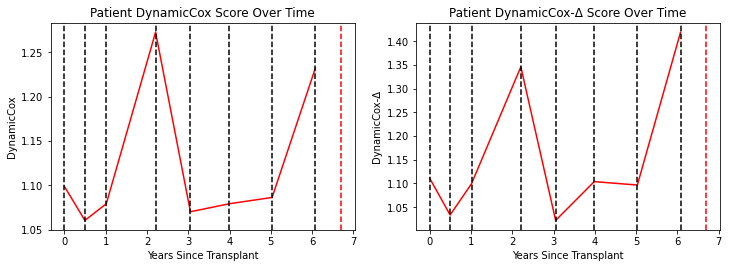

In [101]:
make_multivariable_longitudinal_plot(graft_df, 851983.0, "Graft-Failure", save=True)

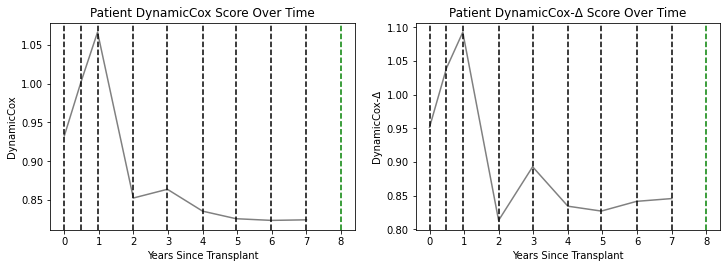

In [100]:
make_multivariable_longitudinal_plot(graft_df,  689395.0, "Graft-Failure", save=True)